# A quick introduction to quantum machine learning

Quantum machine learning is a relatively new field of research, and its core idea is very similar to the classical approach. The main difference is that, instead of a neural network, we use a quantum circuit (ansatz) to perform the learning task.

In the literature, you can find various strategies, including hybrid approaches. For simple datasets with a small number of features, it is possible to use a fully quantum neural network, which is what we will focus on today.

However, when working with more complex data such as images, hybrid methods are necessary—for example, using convolutional layers on a classical CPU combined with quantum processing for other parts of the model.


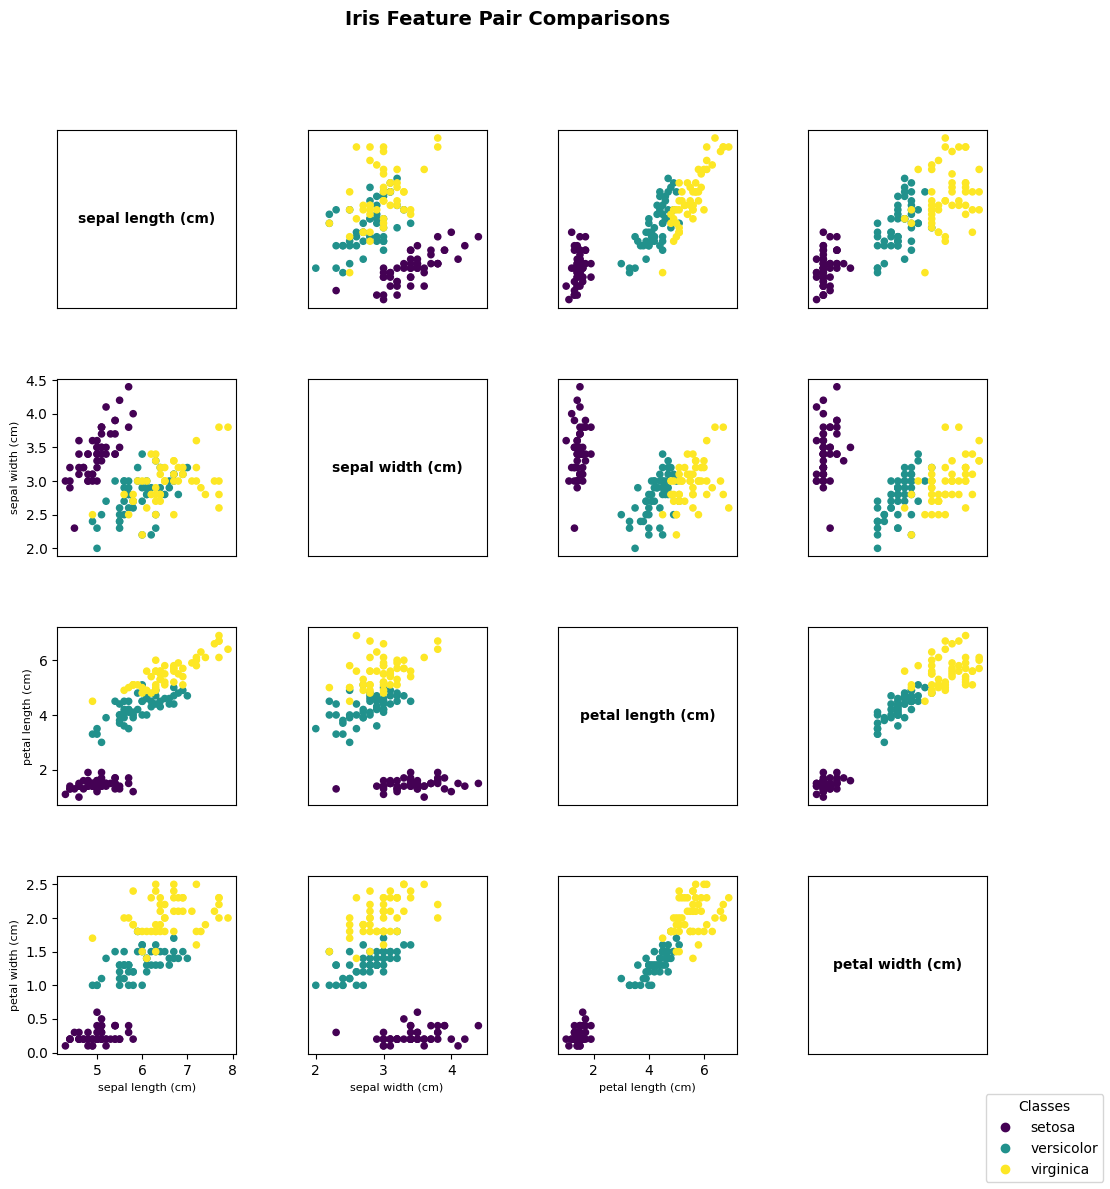

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

def plot_iris_feature_comparison():
    iris = load_iris()
    X = iris.data
    y = iris.target
    feature_names = iris.feature_names
    target_names = iris.target_names

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    for i in range(4):
        for j in range(4):
            ax = axes[i, j]
            if i == j:
                ax.text(0.5, 0.5, feature_names[i],
                        ha='center', va='center', fontsize=10, fontweight='bold')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                scatter = ax.scatter(X[:, j], X[:, i], c=y, cmap='viridis', s=20)
                if i == 3:
                    ax.set_xlabel(feature_names[j], fontsize=8)
                else:
                    ax.set_xticks([])
                if j == 0:
                    ax.set_ylabel(feature_names[i], fontsize=8)
                else:
                    ax.set_yticks([])

    handles, labels = scatter.legend_elements()
    fig.legend(handles, target_names, loc='lower right', title='Classes')
    fig.suptitle('Iris Feature Pair Comparisons', fontsize=14, fontweight='bold')
    plt.show()

plot_iris_feature_comparison()


# Preparing the Dataset

The first step in quantum machine learning is to prepare the dataset so it can be encoded into quantum states. In this example, we use the well-known Iris dataset from scikit-learn. The preparation process includes several stages:

* The Iris dataset is loaded using load_iris().
* The feature values are normalized so that all inputs lie within a comparable range. This helps avoid biases when encoding data into quantum circuits.
* Splitting into Training and Test Sets.
* The normalized data is divided into a training set and a test set using an 80/20 split (train_test_split).
* To keep the classification problem simple, we limit the number of classes with the num_classes parameter.
* By default, we choose two classes out of the three available in the Iris dataset.
* This scaling maps the data to the range $[0,2π]$, which is a natural choice for encoding into rotational angles in quantum gates.
* If verbose=True, the function prints the prepared training and test sets for inspection.


In [2]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import numpy as np

def prepare_dataset(num_classes=2, test_size=0.2, verbose=True):
    iris = load_iris()
    X = normalize(iris.data)
    y = iris.target

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    max_classes = len(set(y_test))
    assert 2 <= num_classes <= max_classes, f"num_classes must be between 2 and {max_classes}"

    allowed_labels = set(range(num_classes))
    train_mask = [label in allowed_labels for label in y_train]
    test_mask = [label in allowed_labels for label in y_test]

    X_train = X_train[train_mask] * (2 * np.pi)
    y_train = y_train[train_mask]
    X_test = X_test[test_mask] * (2 * np.pi)
    y_test = y_test[test_mask]

    if verbose:
        print("Training set:")
        print(X_train)
        print(y_train)
        print("\nTest set:")
        print(X_test)
        print(y_test)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_dataset(num_classes=2)


Training set:
[[4.87431135 3.81467845 1.0596329  0.21192658]
 [4.8619986  3.75312173 1.27947332 0.34119288]
 [4.83462486 2.23691598 3.17497752 1.01022012]
 [4.94481031 3.50257397 1.6482701  0.20603376]
 [4.9391515  3.59211018 1.45929476 0.22450689]
 [4.68409936 2.34204968 3.29350736 1.09783579]
 [5.06688409 3.41040275 1.46160118 0.19488016]
 [4.96977964 3.57824134 1.3915383  0.19879119]
 [4.81155718 3.79372777 1.38794919 0.09252995]
 [4.49404424 2.54662507 3.37053318 1.1984118 ]
 [4.74112454 2.19365464 3.32586348 1.06144579]
 [4.99066775 3.60437115 1.20145705 0.36967909]
 [5.05001712 3.46019692 1.40278253 0.18703767]
 [4.8533161  2.11781066 3.2649581  0.88242111]
 [4.82458942 2.19299519 3.21639295 1.02339776]
 [4.61475121 2.34785588 3.400343   1.05248712]
 [4.43793265 2.37746392 3.56619588 1.18873196]
 [5.05025328 3.46586009 1.38634404 0.19804915]
 [4.75489456 2.2134854  3.36121857 0.81980941]
 [5.12767151 3.35270829 1.38052694 0.19721813]
 [5.0286406  3.52004842 1.30744655 0.30171844]

# Circut building

The construction of a quantum circuit starts with selecting an appropriate Feature Map, which is responsible for translating classical data into quantum states. This mapping is achieved using rotation gates $R_x$. After first placing each qubit into a superposition state, the rotation gates adjust their positions on the Bloch sphere to represent the input features (with limited precision and some inherent error).

At this stage, it becomes clear how many qubits the circuit requires: each feature must be encoded onto a separate qubit. In the case of the Iris dataset, which has four features, we need exactly four qubits.

Two of the most commonly used feature maps are ZFeatureMap and ZZFeatureMap, though others exist. The ZZFeatureMap differs by additionally entangling the qubits, which is recommended when the features are correlated with each other.

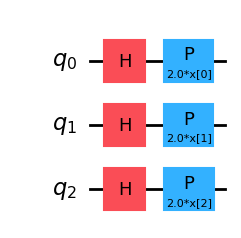

In [3]:
from qiskit.circuit.library import ZFeatureMap
num_qubits = 3
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1).decompose()
feature_map.draw("mpl")

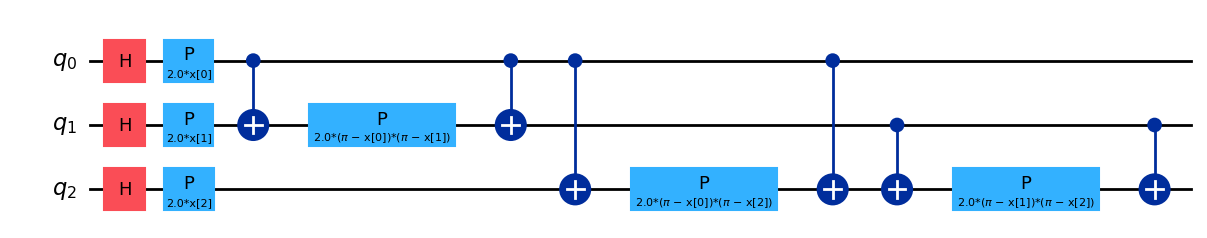

In [4]:
from qiskit.circuit.library import ZZFeatureMap
num_qubits = 3
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1).decompose()
feature_map.draw("mpl")

# Building the Main Part of the Quantum Neural Network

After encoding the input data into quantum states, we move on to the core part of our quantum neural network. A convenient option is to use a predefined ansatz, such as RealAmplitudes, which is very popular in quantum machine learning (QML) but is also used in other contexts.

This ansatz is based on $R_y$ rotation gates. It starts with an initial layer of $R_y$ gates, followed by an entangling layer composed of CNOT gates, which successively entangle neighboring qubits. After the CNOT operations, another layer of $R_y$ gates is applied to each qubit.

For example, with two layers, the RealAmplitudes circuit contains 3 + 6  = 9 trainable parameters in total.

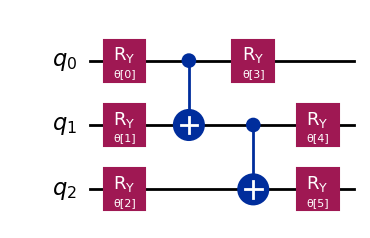

In [5]:
from qiskit.circuit.library import RealAmplitudes
real = RealAmplitudes(num_qubits, reps=1, entanglement="linear").decompose()
real.draw("mpl")

You can propose your own variational circuit by modifying standard ansatze like RealAmplitudes. In this example, the circuit keeps the same structure—initial $R_y$  rotations followed by entangling CNOT layers and additional parameterized rotations—but adds an extra CNOT connection between the last and the first qubit to increase entanglement. Barriers are included only in verbose mode to improve readability when visualizing the circuit. This simple change creates a custom ansatz that may better capture correlations in certain datasets while remaining close to the familiar RealAmplitudes design.

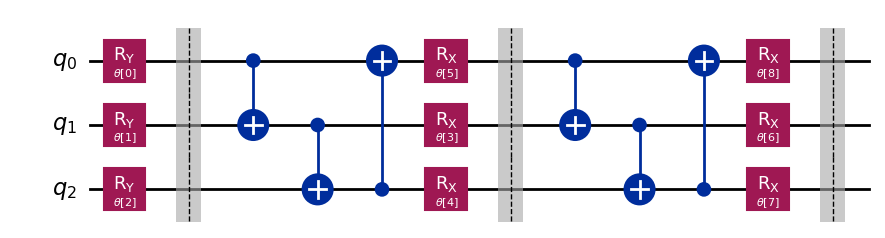

In [6]:
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit
def custom_variational_circuit(num_qubits = 4, num_layers = 2, verbose = False):
    theta = ParameterVector(r"$\theta$", num_qubits + num_qubits * num_layers)
    qc = QuantumCircuit(num_qubits)
    id = 0
    for q in range(num_qubits):
        qc.ry(theta[id], q)
        id += 1
    if verbose:
        qc.barrier()
    for _ in range(num_layers):
        for q in range(num_qubits):
            qc.cx(q, (q + 1) % num_qubits)
        for q in range(num_qubits):
            # qc.cx(q, (q + 1) % num_qubits)
            qc.rx(theta[id], (q + 1) % num_qubits)
            id += 1
        if verbose:
            qc.barrier()
        
    return qc
qc = custom_variational_circuit(num_qubits = 3, num_layers = 2, verbose=True)
qc.draw("mpl")

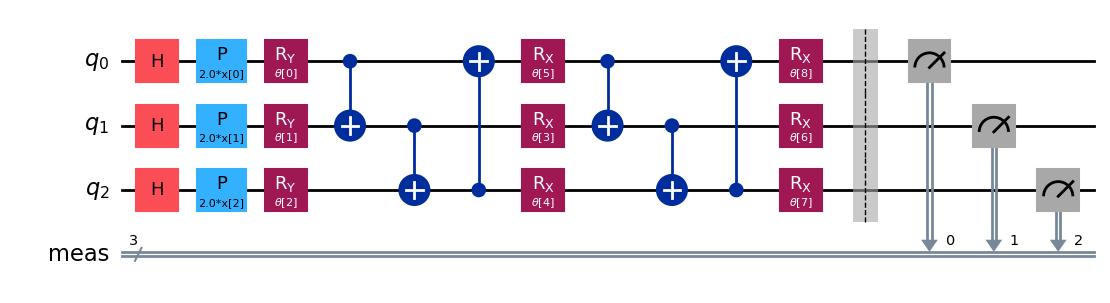

In [15]:
def build_circuit(
    num_qubits,
    num_layers,
    feature_map_type="ZZFeatureMap",
    feature_reps=1,
    ansatz_type="ra",
    verbose = False
):
    qc = QuantumCircuit(num_qubits)
    if feature_map_type == "ZFeatureMap":
        feature_map =  ZFeatureMap(feature_dimension=num_qubits, reps=feature_reps).decompose()
    elif feature_map_type == "ZZFeatureMap":
        feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=feature_reps).decompose()
    else:
        raise ValueError(f"Unsupported feature_map_type: {feature_map_type}")
    if ansatz_type == "ra":
        ansatz = RealAmplitudes(num_qubits, reps=num_layers, entanglement="linear").decompose()
    elif ansatz_type == "custom":
        ansatz = custom_variational_circuit(num_qubits, num_layers)
    else:
        raise ValueError(f"Unsupported ansatz_type: {ansatz_type}")
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    qc.measure_all()
    return qc

# qc = build_circuit(3, 2, feature_map_type="ZFeatureMap", verbose=True, ansatz_type = "ra")
qc = build_circuit(3, 2, feature_map_type="ZFeatureMap", verbose=True, ansatz_type = "custom")
qc.draw("mpl")

We need define the **loss calculation, probability interpretation, and gradient estimation** used in training the quantum classifier:

The `loss_function()` computes the **negative log-likelihood** for a predicted probability distribution. It ensures numerical stability by adding a small value $\epsilon$ to avoid taking the logarithm of zero.

The `interpret_counts_as_class_probabilities()` function converts **measurement counts** (bitstrings returned from a quantum circuit) into a **class probability vector**. Each bitstring is mapped to a class index, counts are accumulated, and the result is normalized to form a valid probability distribution.

The `gradient()` function estimates the **parameter gradient** using the **finite-difference method**. For each parameter $\theta_i$, it perturbs the value slightly in both positive and negative directions ($\theta_i \pm \delta$), evaluates the circuit for both cases, computes the corresponding losses, and approximates the derivative as the difference divided by $2\delta$. This gradient vector is then used to update the circuit’s parameters during training.


In [16]:
def loss_function(probabilities, target):
    epsilon = 1e-10
    num_classes = len(probabilities)
    target_vec = np.zeros(num_classes)
    target_vec[target] = 1
    return -np.log(probabilities[target] + epsilon)

def interpret_counts_as_class_probabilities(counts, num_classes):
    logit_vector = np.zeros(num_classes)
    for bitstring, count in counts.items():
        idx = int(bitstring, 2) % num_classes
        logit_vector[idx] += count
    total = np.sum(logit_vector)
    probabilities = logit_vector / total if total > 0 else np.ones(num_classes) / num_classes
    return probabilities
def gradient(X, Y, theta, circ, sampler, num_classes, delta=1e-2):
    grad = []

    for i in range(len(theta)):
        theta_plus = theta.copy()
        theta_minus = theta.copy()
        theta_plus[i] += delta
        theta_minus[i] -= delta

        params_plus = np.concatenate([X, theta_plus])
        params_minus = np.concatenate([X, theta_minus])

        job = sampler.run([
            (circ, params_plus),
            (circ, params_minus)
        ], shots=1024)
        result = job.result()

        counts_plus = result[0].data.meas.get_counts()
        counts_minus = result[1].data.meas.get_counts()
        probs_plus = interpret_counts_as_class_probabilities(counts_plus, num_classes)
        probs_minus = interpret_counts_as_class_probabilities(counts_minus, num_classes)
        loss_plus = loss_function(probs_plus, Y)
        loss_minus = loss_function(probs_minus, Y)
        grad_i = (loss_plus - loss_minus) / (2 * delta)
        grad.append(grad_i)

    
    return np.array(grad)

code performs **training of a Variational Quantum Classifier (VQC)** using gradient-based optimization. It starts by determining the number of trainable parameters in the ansatz and initializing them—either randomly (using a fixed seed for reproducibility) or from user-provided values. The training loop runs for `maxiter` iterations. In each iteration:

* A mini-batch of training samples is randomly selected.
* For every sample, the `gradient` function estimates parameter gradients using the finite-difference method by slightly perturbing each parameter and comparing the resulting losses.
* Gradients are accumulated, and the parameter vector `thetas` is updated using the specified learning rate, scaled by the batch size.
* After parameter updates, the current loss is evaluated by running the circuit with the updated parameters, converting measurement counts to class probabilities, and computing the average batch loss with `loss_function`.

The process tracks loss values in `loss_history`. If `verbose` is enabled, the function prints progress details for each sample, the loss per iteration, and finally plots the training loss curve. The function returns the optimized parameters `thetas`, which can then be used for testing or further evaluation of the quantum model.


number of parametrs: 44
Initial theta: [-0.78828768  2.83192151  1.45766093  0.61988954 -2.16129862 -2.16145018
 -2.77664256  2.30075258  0.63532436  1.30735856 -3.01225646  2.95253068
  2.08879872 -1.80742667 -1.99915269 -1.98922813 -1.22998226  0.15554925
 -0.42760206 -1.311746    0.70279246 -2.26512688 -1.30599369 -0.8396733
 -0.27602043  1.79181341 -1.88700528  0.08943761  0.58065786 -2.8497361
  0.67572423 -2.07015799 -2.73286144  2.82043101  2.92565235  1.93771769
 -1.22764789 -2.52790066  1.15757025 -0.37603297 -2.37480381 -0.03030437
 -2.9255232   2.57183594]
1/4 sample in batch
2/4 sample in batch
3/4 sample in batch
4/4 sample in batch
Custom Iteration 0 - Loss: 0.5837
1/4 sample in batch
2/4 sample in batch
3/4 sample in batch
4/4 sample in batch
Custom Iteration 1 - Loss: 0.5260
1/4 sample in batch
2/4 sample in batch
3/4 sample in batch
4/4 sample in batch
Custom Iteration 2 - Loss: 0.5303
1/4 sample in batch
2/4 sample in batch
3/4 sample in batch
4/4 sample in batch
Cust

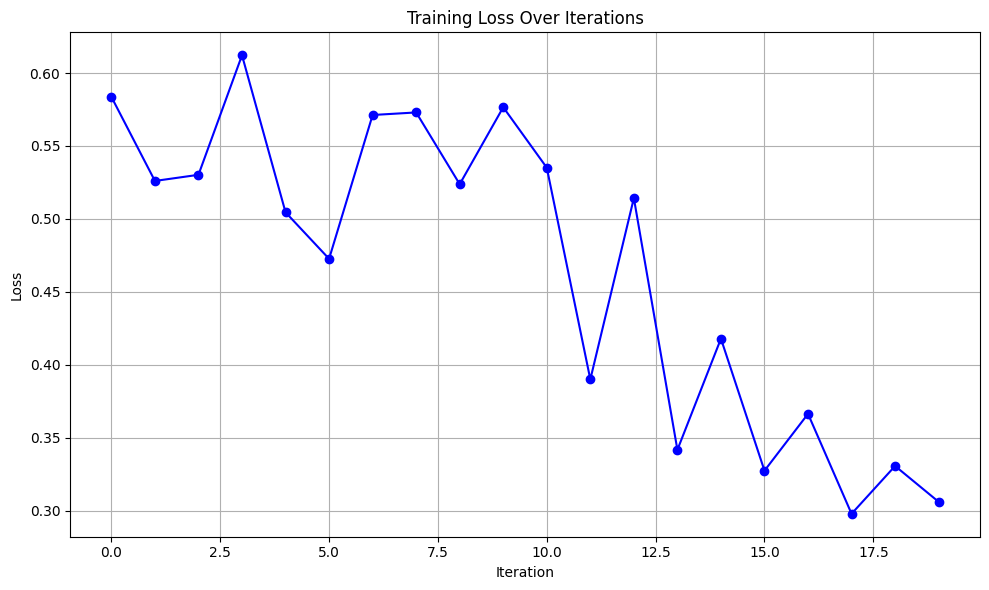

In [17]:
from qiskit_aer.primitives import SamplerV2
def train_vqc(
    X_train, y_train, ansatz, sampler, num_classes,  maxiter=10, batch_size=4, shots=2048,
    verbose=True, learning_rate = 0.01, theta_seed = 42,init_thetas = None
):
    theta_count = len(list(ansatz.parameters)) - 4
    print("number of parametrs:", theta_count)
    np.random.seed(theta_seed)
    initial_theta = init_thetas
    if initial_theta == None:
        initial_theta = np.random.uniform(-np.pi, np.pi, theta_count)

    if verbose:
        print("Initial theta:", initial_theta)

    thetas = initial_theta.copy()

    loss_history=[]
    
    for i in range(maxiter):
        total_loss = 0
        grad_sum = np.zeros_like(thetas)
        indices = np.random.choice(len(X_train), batch_size, replace=False)

        # for idx in indices:
        for s, idx in enumerate(indices, start=1):
            if verbose:
                print(f"{s}/{len(indices)} sample in batch")
            x_i = X_train[idx]
            y_i = y_train[idx]

            grad = gradient(x_i, y_i, thetas, ansatz, sampler, num_classes, delta=1e-2)
            grad_sum += grad
            thetas -= (learning_rate / batch_size) * grad_sum


        for idx in indices:
            x_i = X_train[idx]
            y_i = y_train[idx]
            full_params = np.concatenate([x_i, thetas])
            job = sampler.run([(ansatz, full_params)], shots=shots)
            result = job.result()
            counts = result[0].data.meas.get_counts()
            # counts = quantum_job(x_i,thetas , circ, sampler, shots)
            probs = interpret_counts_as_class_probabilities(counts, num_classes)
            total_loss += loss_function(probs, y_i)
        avg_loss = total_loss / batch_size
        loss_history.append(avg_loss)
        if verbose:
            print(f"Custom Iteration {i} - Loss: {avg_loss:.4f}")
    if verbose:
        plt.figure(figsize=(10, 6))
        plt.plot(loss_history, marker='o', color='blue')
        plt.title('Training Loss Over Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.tight_layout()
    
    return thetas
Num_classes = 2
qc = build_circuit(4, 10, feature_map_type="ZFeatureMap", verbose=False, ansatz_type = "ra")
X_train, X_test, y_train, y_test = prepare_dataset(num_classes=Num_classes, verbose = False)
sampler = SamplerV2()
thetas = train_vqc(X_train, y_train, qc, sampler, Num_classes, maxiter = 20)

For each test sample in `X_test`, the feature vector is concatenated with the trained parameters `theta_values` and fed into the quantum circuit `circ`. The circuit is executed using the provided `sampler` with a specified number of shots, and the measurement results are collected.

The raw measurement counts are converted into class probabilities using `interpret_counts_as_class_probabilities`. The predicted class is then chosen as the index of the maximum probability (`np.argmax`). After generating predictions for the entire test set, the function calculates the **accuracy score** and a **classification report** (precision, recall, F1-score) using scikit-learn’s `accuracy_score` and `classification_report`.

If `verbose` is enabled, the accuracy and full classification report are printed for easier inspection. The function finally returns both the accuracy and the classification report, enabling further analysis or integration into other workflows.


In [18]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

def evaluate_vqc(X_test, y_test, theta_values, circ, sampler, num_classes, shots=1024, verbose=True):
    y_pred = []
    for x in X_test:
        full_params = np.concatenate([x, theta_values])
        job = sampler.run([(circ, full_params)], shots=shots)
        result = job.result()
        counts = result[0].data.meas.get_counts()
        probabilities = interpret_counts_as_class_probabilities(counts, num_classes)
        y_pred.append(np.argmax(probabilities))

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)

    if verbose:
        print(f"Accuracy: {acc:.4f}")
        print("Classification report:")
        print(report)

    return acc, report

evaluate_vqc(X_test, y_test, thetas, qc, sampler, Num_classes)

Accuracy: 1.0000
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



(1.0,
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        10\n           1       1.00      1.00      1.00         9\n\n    accuracy                           1.00        19\n   macro avg       1.00      1.00      1.00        19\nweighted avg       1.00      1.00      1.00        19\n')

This version of the evaluation function is **nearly identical** to the standard `evaluate_vqc`, but it includes several small changes required for running on the **ODRA 5 quantum computer**:

* **Backend handling**: Instead of using a local `Sampler`, the code retrieves the quantum backend via `get_spark_backend()` and transpiles (`transpile`) each parameterized circuit to match the hardware requirements.
* **Batch execution**: All transpiled circuits are stored in a list (`circs`) and sent together to the backend (`backend.run(circs, shots=shots)`), improving efficiency when working with a real device.
* **Result handling**: The backend returns a list of count dictionaries (`get_counts()` for each circuit), which are then processed to obtain class probabilities and predictions.

Other than these adjustments for hardware compatibility and efficiency, the workflow—parameter assignment, probability interpretation, accuracy computation, and reporting—remains the same as in the previous evaluation function.


In [14]:
from qiskit import transpile
import os


def getRealBackend(env = 'secret.env'):
    from dotenv import load_dotenv
    from iqm.qiskit_iqm.iqm_provider import IQMProvider

    load_dotenv(env)

    os.environ["IQM_TOKENS_FILE"] = r"/home/xederro/.cache/iqm-client-cli/tokens.json"

    iqm_url = "https://odra5.e-science.pl/station"
    provider = IQMProvider(iqm_url)

    return provider.get_backend()

def evaluate_vqc_spark(X_test, y_test, theta_values, circ, backend, num_classes, use_softmax=True, shots=1024, verbose=True):
    
    params = list(circ.parameters)
    y_pred = []
    circs = []
    for x in X_test:
        
        full_params = np.concatenate([x, theta_values])
        assignments = dict(zip(params, full_params))
        assigned_circ = circ.assign_parameters(assignments)

        trans = transpile(assigned_circ, backend=backend)
        circs.append(trans)
    
    job = backend.run(circs, shots=shots)
    result = job.result()
    counts_list = result.get_counts()
    for counts in counts_list:
        probabilities = interpret_counts_as_class_probabilities(counts, num_classes)
        y_pred.append(np.argmax(probabilities))

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)

    if verbose:
        print(f"Accuracy: {acc:.4f}")
        print("Classification report:")
        print(report)

    return acc, report
backend = getRealBackend()
acc, report = evaluate_vqc_spark(X_test, y_test, thetas, qc, backend, Num_classes)

station-control-client version '9.8.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.


Accuracy: 0.8421
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



Task 1: Compare the performance of two circuits: (1) the standard RealAmplitudes ansatz and (2) the custom ansatz with an additional CNOT gate between the last and the first qubit.


number of parametrs: 44
Initial theta: [-0.78828768  2.83192151  1.45766093  0.61988954 -2.16129862 -2.16145018
 -2.77664256  2.30075258  0.63532436  1.30735856 -3.01225646  2.95253068
  2.08879872 -1.80742667 -1.99915269 -1.98922813 -1.22998226  0.15554925
 -0.42760206 -1.311746    0.70279246 -2.26512688 -1.30599369 -0.8396733
 -0.27602043  1.79181341 -1.88700528  0.08943761  0.58065786 -2.8497361
  0.67572423 -2.07015799 -2.73286144  2.82043101  2.92565235  1.93771769
 -1.22764789 -2.52790066  1.15757025 -0.37603297 -2.37480381 -0.03030437
 -2.9255232   2.57183594]
1/4 sample in batch
2/4 sample in batch
3/4 sample in batch
4/4 sample in batch
Custom Iteration 0 - Loss: 0.6741
1/4 sample in batch
2/4 sample in batch
3/4 sample in batch
4/4 sample in batch
Custom Iteration 1 - Loss: 0.6026
1/4 sample in batch
2/4 sample in batch
3/4 sample in batch
4/4 sample in batch
Custom Iteration 2 - Loss: 0.5892
1/4 sample in batch
2/4 sample in batch
3/4 sample in batch
4/4 sample in batch
Cust

(0.9473684210526315,
 '              precision    recall  f1-score   support\n\n           0       0.91      1.00      0.95        10\n           1       1.00      0.89      0.94         9\n\n    accuracy                           0.95        19\n   macro avg       0.95      0.94      0.95        19\nweighted avg       0.95      0.95      0.95        19\n')

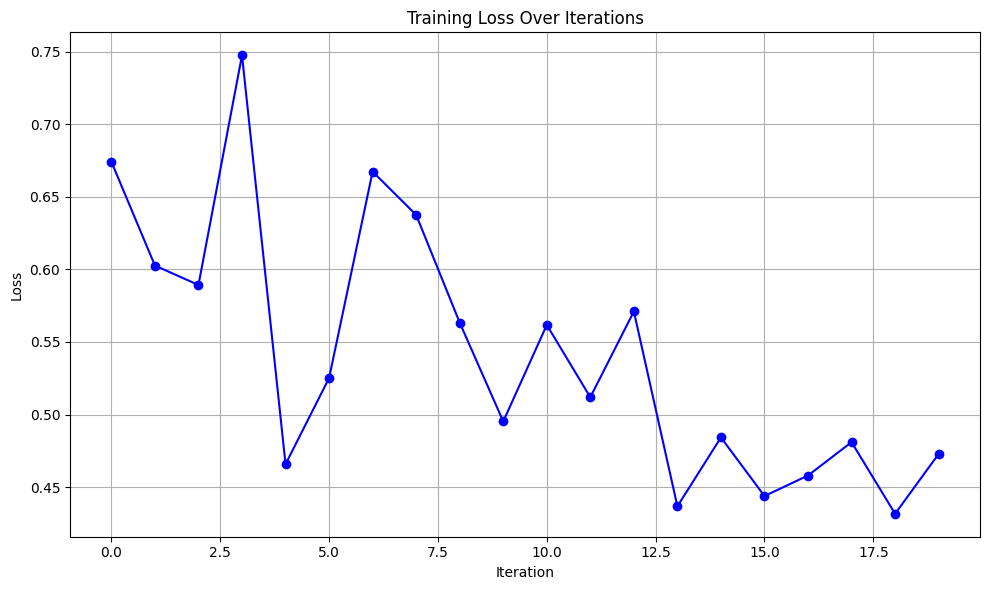

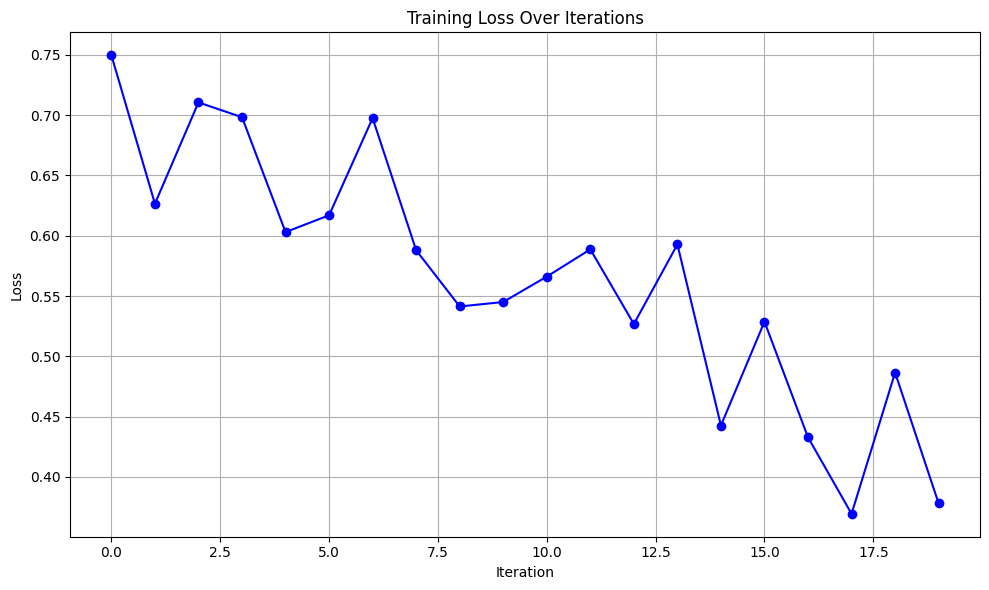

In [20]:
# RA
Num_classes = 2
qc = build_circuit(4, 10, feature_map_type="ZFeatureMap", verbose=False, ansatz_type = "ra")
X_train, X_test, y_train, y_test = prepare_dataset(num_classes=Num_classes, verbose = False)
sampler = SamplerV2()
thetas = train_vqc(X_train, y_train, qc, sampler, Num_classes, maxiter = 20)
evaluate_vqc(X_test, y_test, thetas, qc, sampler, Num_classes)
# custom
qc = build_circuit(4, 10, feature_map_type="ZFeatureMap", verbose=False, ansatz_type = "custom")
X_train, X_test, y_train, y_test = prepare_dataset(num_classes=Num_classes, verbose = False)
sampler = SamplerV2()
thetas = train_vqc(X_train, y_train, qc, sampler, Num_classes, maxiter = 20)
evaluate_vqc(X_test, y_test, thetas, qc, sampler, Num_classes)

Task 2: Perform classification for three classes using your chosen variational quantum classifier.

number of parametrs: 44
Initial theta: [-0.78828768  2.83192151  1.45766093  0.61988954 -2.16129862 -2.16145018
 -2.77664256  2.30075258  0.63532436  1.30735856 -3.01225646  2.95253068
  2.08879872 -1.80742667 -1.99915269 -1.98922813 -1.22998226  0.15554925
 -0.42760206 -1.311746    0.70279246 -2.26512688 -1.30599369 -0.8396733
 -0.27602043  1.79181341 -1.88700528  0.08943761  0.58065786 -2.8497361
  0.67572423 -2.07015799 -2.73286144  2.82043101  2.92565235  1.93771769
 -1.22764789 -2.52790066  1.15757025 -0.37603297 -2.37480381 -0.03030437
 -2.9255232   2.57183594]
1/4 sample in batch
2/4 sample in batch
3/4 sample in batch
4/4 sample in batch
Custom Iteration 0 - Loss: 0.8735
1/4 sample in batch
2/4 sample in batch
3/4 sample in batch
4/4 sample in batch
Custom Iteration 1 - Loss: 0.9781
1/4 sample in batch
2/4 sample in batch
3/4 sample in batch
4/4 sample in batch
Custom Iteration 2 - Loss: 0.8769
1/4 sample in batch
2/4 sample in batch
3/4 sample in batch
4/4 sample in batch
Cust

(0.8,
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        10\n           1       0.60      1.00      0.75         9\n           2       1.00      0.45      0.62        11\n\n    accuracy                           0.80        30\n   macro avg       0.87      0.82      0.79        30\nweighted avg       0.88      0.80      0.79        30\n')

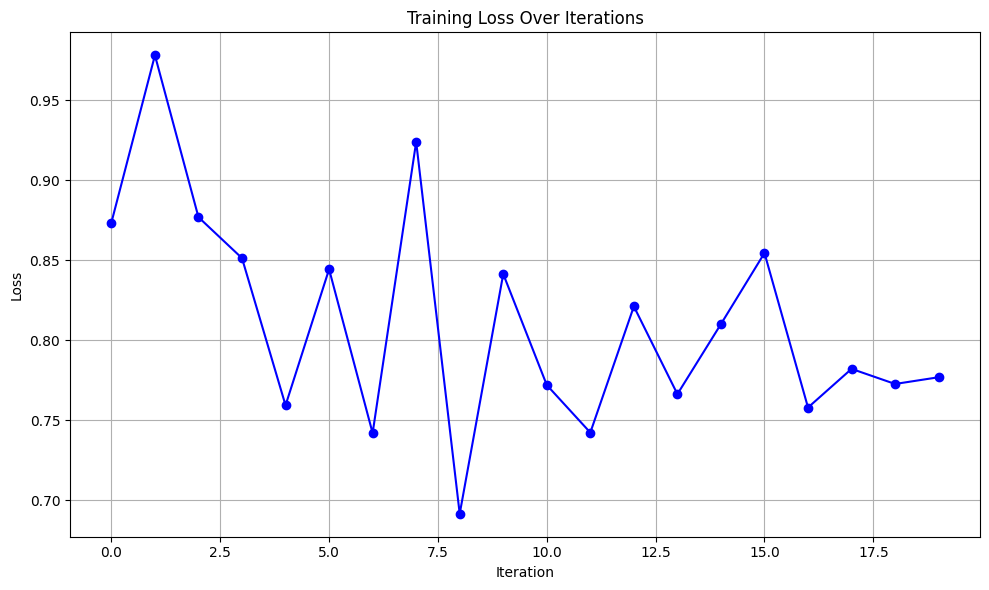

In [21]:
# RA
Num_classes = 3
qc = build_circuit(4, 10, feature_map_type="ZFeatureMap", verbose=False, ansatz_type = "ra")
X_train, X_test, y_train, y_test = prepare_dataset(num_classes=Num_classes, verbose = False)
sampler = SamplerV2()
thetas = train_vqc(X_train, y_train, qc, sampler, Num_classes, maxiter = 20)
evaluate_vqc(X_test, y_test, thetas, qc, sampler, Num_classes)

Task 3: Propose and train your own circuit design, then evaluate its performance.